##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Google Search Grounding

In this optional notebook, you will use [Google Search](https://google.com/) results with the Gemini API in a technique called grounding, where the model is connected to verifiable sources of information. Using search grounding is similar to using the RAG system you implemented earlier in the week, but the Gemini API automates a lot of it for you. The model generates Google Search queries and invokes the searches automatically, retrieving relevant data from Google's index of the web and providing links to search suggestions that support the query, so your users can verify the sources.

## New in Gemini 2.0

Gemini 2.0 Flash provides a generous Google Search quota as part of the [free tier](https://ai.google.dev/pricing). If you switch models back to 1.5, you will need to [enable billing](https://aistudio.google.com/apikey) to use Grounding with Google Search, or you can [try it out in AI Studio](https://aistudio.google.com/). See the [earlier versions of this notebook](https://www.kaggle.com/code/markishere/day-4-google-search-grounding?scriptVersionId=207458162) for guidance. 

## Use the API

Start by installing and importing the Gemini API Python SDK.

In [1]:
# Uninstall packages from Kaggle base image that are not needed.
!pip uninstall -qy jupyterlab jupyterlab-lsp
# Install the google-genai SDK for this codelab.
!pip install -qU 'google-genai==1.7.0'

In [2]:
from google import genai
from google.genai import types

from IPython.display import Markdown, HTML, display

genai.__version__

'1.7.0'

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

### Automated retry

In [4]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

## Use search grounding

### Model support

Search grounding is available in a limited set of models. Find a model that supports it on [the models page](https://ai.google.dev/gemini-api/docs/models/gemini).

In this guide, you'll use `gemini-2.0-flash`.

### Make a request

To enable search grounding, you specify it as a tool: `google_search`. Like other tools, this is supplied as a parameter in `GenerateContentConfig`, and can be passed to `generate_content` calls as well as `chats.create` (for all chat turns) or `chat.send_message` (for specific turns).

In [5]:
# Ask for information without search grounding.
response = client.models.generate_content(model='gemini-2.5-flash', contents="When and where is Billie Eilish's next concert?")

Markdown(response.text)

Billie Eilish's next scheduled concert is on **September 29, 2024**, at the **Videotron Centre in Quebec City, QC, Canada**.

This date kicks off her "Hit Me Hard and Soft: The Tour," which will continue through North America and Europe into 2025.

For the most up-to-date and complete schedule, it's always best to check her official website or reputable ticketing sites.

Now try with grounding enabled.

In [6]:
# And now re-run the same query with search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

def query_with_grounding():
    response = client.models.generate_content(
        model='gemini-2.5-flash',
        contents="When and where is Billie Eilish's next concert?",
        config=config_with_search,
    )
    return response.candidates[0]


rc = query_with_grounding()
Markdown(rc.content.parts[0].text)

As of December 22, 2025, Billie Eilish's 2025 North American tour has concluded. Currently, there are no immediate upcoming concert dates announced.

While there is mention of a "Billie Eilish 2026 Global Tour" with potential start dates in March and late November, specific locations and dates have not yet been detailed. Fans are advised to monitor official channels like Ticketmaster and Live Nation for future announcements.

### Response metadata

When search grounding is used, the model returns extra metadata that includes links to search suggestions, supporting documents and information on how the supporting documents were used.

Each "grounding chunk" represents information retrieved from Google Search that was used in the grounded generation request. Following the URI will take you to the source.

In [7]:
while not rc.grounding_metadata.grounding_supports or not rc.grounding_metadata.grounding_chunks:
    # If incomplete grounding data was returned, retry.
    rc = query_with_grounding()

chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(f'{chunk.web.title}: {chunk.web.uri}')

ticketmaster.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEW-0Eq-smeOV7MlGAoEDmGDUCtgREaosr5T7E_P4aX_JBGvg1H1xp69QK7VkKryHpKuGsZHhTFSDpkiETqIYqIG8kUgqahN5b_wR6vKpXpGuIwDQd5tEnYzjn45dDVLHxMnQKZ7pkNHbkD9g3JXnxdqZM5DH9PNWwoLlI=
livenation.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH5NJxtnz9QQ9jio-eb7Z3NwUqbNCHRCog7U99sZcxcKOWhoE8WZv13-UClZHKF8K0c1NcF7AO5PgtF1u_DO9JClYSL6zM2eX90VfKHtIVFvXXSBBbHvgXUuPeYdGBiC-yvYelGPZBiMKH1w5G0z5yv2oUgv_S4tOHGb0fv
vividseats.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGLcW7ytPeoFW8CWen2g6gNtnZJa5TwLo_rXQK9jQYxzwXbEaxSzadZsfRg0m4BW3U7YoxMVbVbrSXxEXAdJcZfQcJLGXKxxxAMeEWJB8prf1F0VBNjNSdkHWT54bw7yiVdP2zMDUmYjYwLpD24kuRlMg3sl96TqLk5yw==
billieeilishontour.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH3VrBONPQRstlwL5wtxHlqSek_8IzH7R3MSrDBi3Cm_70MXwNpDWWO8ugbrqGrHM2mSXWNOXHgdPMLm3rXWVznKG6kh1NEZmUSSt-ANn4fgOeb4MkuhvQzLQ==


As part of the response, there is a standalone styled HTML content block that you use to link back to relevant search suggestions related to the generation.

In [8]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)

The `grounding_supports` in the metadata provide a way for you to correlate the grounding chunks used to the generated output text.

In [9]:
from pprint import pprint

supports = rc.grounding_metadata.grounding_supports
for support in supports:
    pprint(support.to_json_dict())

{'grounding_chunk_indices': [0],
 'segment': {'end_index': 80,
             'text': "As of December 22, 2025, Billie Eilish's 2025 North "
                     'American tour has concluded.'}}
{'grounding_chunk_indices': [1, 2],
 'segment': {'end_index': 148,
             'start_index': 81,
             'text': 'Currently, there are no immediate upcoming concert dates '
                     'announced.'}}
{'grounding_chunk_indices': [3],
 'segment': {'end_index': 322,
             'start_index': 150,
             'text': 'While there is mention of a "Billie Eilish 2026 Global '
                     'Tour" with potential start dates in March and late '
                     'November, specific locations and dates have not yet been '
                     'detailed.'}}


These supports can be used to highlight text in the response, or build tables of footnotes.

In [10]:
import io

markdown_buffer = io.StringIO()

# Print the text with footnote markers.
markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        rc.content.parts[0].text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")


# And print the footnotes.
markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"{i}. [{chunk.web.title}]({chunk.web.uri})\n")


Markdown(markdown_buffer.getvalue())

Supported text:

 * As of December 22, 2025, Billie Eilish's 2025 North American tour has concluded.<sup>[1]</sup>

 * Currently, there are no immediate upcoming concert dates announced.<sup>[2]</sup><sup>[3]</sup>

 * While there is mention of a "Billie Eilish 2026 Global Tour" with potential start dates in March and late November, specific locations and dates have not yet been detailed.<sup>[4]</sup>

Citations:

1. [ticketmaster.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEW-0Eq-smeOV7MlGAoEDmGDUCtgREaosr5T7E_P4aX_JBGvg1H1xp69QK7VkKryHpKuGsZHhTFSDpkiETqIYqIG8kUgqahN5b_wR6vKpXpGuIwDQd5tEnYzjn45dDVLHxMnQKZ7pkNHbkD9g3JXnxdqZM5DH9PNWwoLlI=)
2. [livenation.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH5NJxtnz9QQ9jio-eb7Z3NwUqbNCHRCog7U99sZcxcKOWhoE8WZv13-UClZHKF8K0c1NcF7AO5PgtF1u_DO9JClYSL6zM2eX90VfKHtIVFvXXSBBbHvgXUuPeYdGBiC-yvYelGPZBiMKH1w5G0z5yv2oUgv_S4tOHGb0fv)
3. [vividseats.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGLcW7ytPeoFW8CWen2g6gNtnZJa5TwLo_rXQK9jQYxzwXbEaxSzadZsfRg0m4BW3U7YoxMVbVbrSXxEXAdJcZfQcJLGXKxxxAMeEWJB8prf1F0VBNjNSdkHWT54bw7yiVdP2zMDUmYjYwLpD24kuRlMg3sl96TqLk5yw==)
4. [billieeilishontour.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQH3VrBONPQRstlwL5wtxHlqSek_8IzH7R3MSrDBi3Cm_70MXwNpDWWO8ugbrqGrHM2mSXWNOXHgdPMLm3rXWVznKG6kh1NEZmUSSt-ANn4fgOeb4MkuhvQzLQ==)


## Search with tools

In this example, you'll use enable the Google Search grounding tool and the code generation tool across two steps. In the first step, the model will use Google Search to find the requested information and then in the follow-up question, it generates code to plot the results.

This usage includes textual, visual and code parts, so first define a function to help visualise these.

In [11]:
from IPython.display import display, Image, Markdown

def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))

Now start a chat asking for some information. Here you provide the Google Search tool so that the model can look up data from Google's Search index.

In [13]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature=0.0,
)

chat = client.chats.create(model='gemini-2.5-flash')

response = chat.send_message(
    message="What were the medal tallies, by top-10 countries, for the 2024 olympics?",
    config=config_with_search,
)

show_response(response)

The 2024 Summer Olympics, held in Paris, France, from July 26 to August 11, 2024, have concluded. The United States topped the medal table for the fourth consecutive Summer Games, with China coming in second.

Here are the medal tallies for the top 10 countries:

| Rank | Country             | Gold | Silver | Bronze | Total |
| :--- | :------------------ | :--- | :----- | :----- | :---- |
| 1    | United States       | 40   | 44     | 42     | 126   |
| 2    | China               | 40   | 27     | 24     | 91    |
| 3    | Great Britain       | 14   | 22     | 29     | 65    |
| 4    | France              | 16   | 26     | 22     | 64    |
| 5    | Australia           | 18   | 19     | 16     | 53    |
| 6    | Japan               | 20   | 12     | 13     | 45    |
| 7    | Italy               | 12   | 13     | 15     | 40    |
| 8    | Netherlands         | 15   | 7      | 12     | 34    |
| 9    | Germany             | 12   | 13     | 8      | 33    |
| 10   | Republic of Korea   | 13   | 9      | 10     | 32    |

The United States and China both secured 40 gold medals, but the United States ranked first due to a higher number of silver medals. Japan finished third in gold medals with 20, but sixth in the overall medal count. Host nation France finished fifth in the overall medal count with 64 medals, marking their first top-five finish since the 1996 Summer Olympics.

----

Continuing the chat, now ask the model to convert the data into a chart. The `code_execution` tool is able to generate code to draw charts, execute that code and return the image. You can see the executed code in the `executable_code` part of the response.

Combining results from Google Search with tools like live plotting can enable very powerful use cases that require very little code to run.

{'executable_code': {'code': "import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Data for the top 10 countries from the 2024 Olympics\ndata = {\n    'Country': [\n        'United States', 'China', 'Great Britain', 'France', 'Australia',\n        'Japan', 'Italy', 'Netherlands', 'Germany', 'Republic of Korea'\n    ],\n    'Gold': [40, 40, 14, 16, 18, 20, 12, 15, 12, 13],\n    'Silver': [44, 27, 22, 26, 19, 12, 13, 7, 13, 9],\n    'Bronze': [42, 24, 29, 22, 16, 13, 15, 12, 8, 10],\n    'Total': [126, 91, 65, 64, 53, 45, 40, 34, 33, 32]\n}\n\ndf = pd.DataFrame(data)\n\n# Sort the DataFrame by 'Total' medals in descending order to ensure correct plotting order\ndf_sorted = df.sort_values('Total', ascending=False)\n\n# Melt the DataFrame to a long format suitable for seaborn's stacked bar chart\ndf_melted = df_sorted.melt(id_vars=['Country', 'Total'], value_vars=['Gold', 'Silver', 'Bronze'],\n                           var_name='Medal Type', value_name='Count')

----

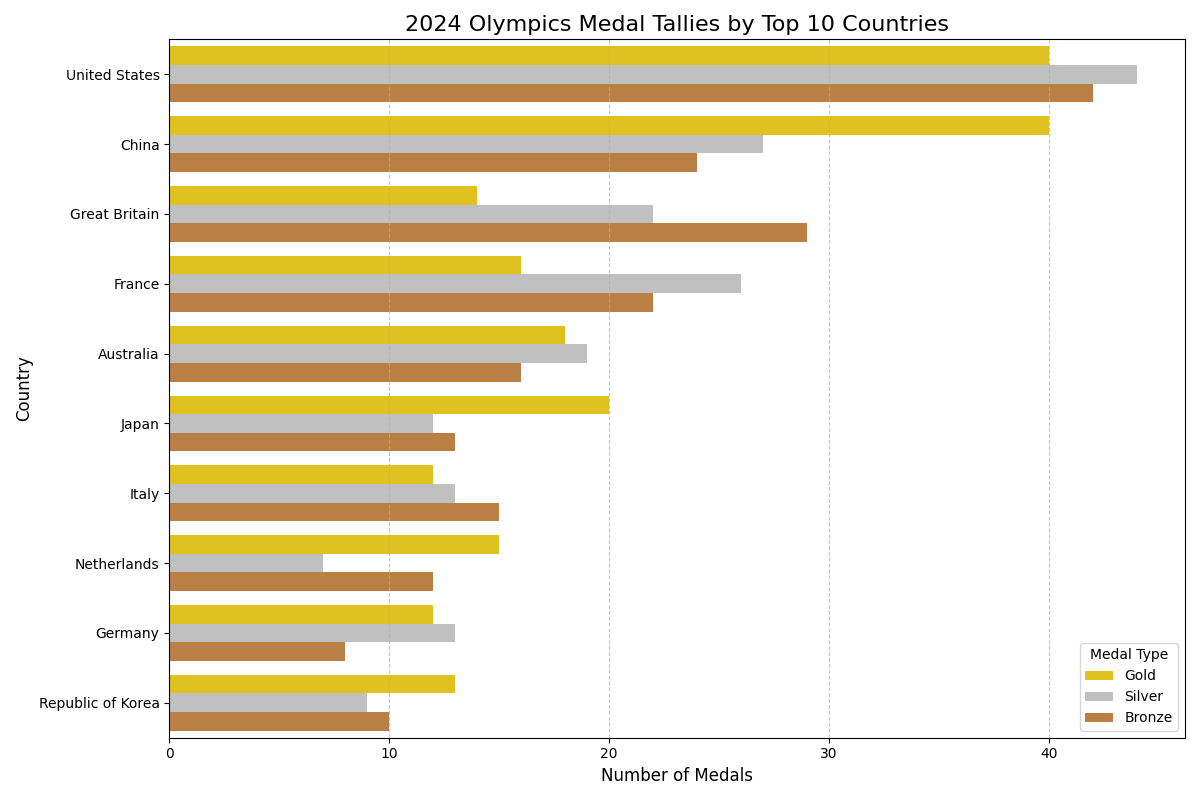

----

Here is the seaborn chart displaying the medal tallies for the top 10 countries at the 2024 Olympics, broken down by Gold, Silver, and Bronze medals. The countries are ordered by their total medal count.

----

In [14]:
config_with_code = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    temperature=0.0,
)

response = chat.send_message(
    message="Now plot this as a seaborn chart. Break out the medals too.",
    config=config_with_code,
)

show_response(response)